# Application of Generative Adversial Networks to Colorize Greyscale Images

### Abdul Matin, Marty Wang, Max Rosoff

## Introduction

## Methods and Results

## Datasets

We begin with the standard imports. Everything from the tools needed to access the graphics card to graphing styles is here. In addition, we import timing utilities, progress trackers, and we filter out python warnings.

In [1]:
import os
import sys
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import clear_output, display, HTML
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from skimage import color

import time
import random
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

## Setup

In the next few cells, we setup the tools needed to run the notebook. We handle specific randomization for reproducability, as well as initialize the graphics card. To turn on the card, leave as is, otherwise, you can override the cuda variable to be False.

In [2]:
manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print()
print("Seed:", manualSeed)
print()


Seed: 1112



In [3]:
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if cuda else 'cpu'

print()
print("Running On Cuda:", cuda)


Running On Cuda: True


## Dataset Creation

Next, we extend the Dataset class to handle the conversion to the LAB colorspace.

In [4]:
class ColorizationDataset(Dataset):
    
    def __init__(self, paths, size):
        
        self.transforms = transforms.Compose([
            transforms.Resize((size, size), Image.BICUBIC),
            transforms.CenterCrop(size),
        ])
        
        self.size = size
        self.paths = paths
    
    def __getitem__(self, idx):
        
        img = Image.open(self.paths[idx]).convert("RGB")
        img = np.array(self.transforms(img) if hasattr(self, 'transforms') else img)
        img_lab = color.rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        l = img_lab[[0], ...] / 50 - 1
        ab = img_lab[[1, 2], ...] / 110
        
        return {'L': l, 'ab': ab}
    
    def __len__(self):
        
        return len(self.paths)

def make_dataloaders(batch_size=32, n_workers=os.cpu_count(), **kwargs):
    
    dataset = ColorizationDataset(size=256, **kwargs)
    return DataLoader(dataset, batch_size=batch_size, num_workers=n_workers if device == 'cpu' else 0, shuffle=True)

## Generator

In [5]:
class UnetBlock(nn.Module):
    
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        
        super().__init__()
        
        self.outermost = outermost
        if input_c is None: input_c = nf
        
        downconv = nn.Conv2d(input_c, ni, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        
        elif innermost:
            
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        
        else:
            
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        
        if self.outermost:
            
            return self.model(x)
        
        else:
            
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        
        for _ in range(n_down - 5):
            
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
       
        out_filters = num_filters * 8
        
        for _ in range(3):
            
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        
        return self.model(x)

## Discriminator

In [6]:
class PatchDiscriminator(nn.Module):
    
    def __init__(self, input_c, num_filters=64, n_down=3):
        
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]                                                                 
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        return self.model(x)

## Main Model

Here we put it all together and create the basis of our training loop.

In [7]:
class MainModel(nn.Module):
    
    def __init__(self, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100):
        
        super().__init__()
        
        self.lambda_L1 = lambda_L1
        
        self.net_G = init_weights(Unet(input_c=1, output_c=2, n_down=8, num_filters=64).to(device))
        self.net_D = init_weights(PatchDiscriminator(input_c=3, n_down=3, num_filters=64).to(device))
        
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
        
        self.GANcriterion = GANLoss(loss=nn.MSELoss()).to(device)
        self.L1criterion = nn.L1Loss()
        
    def set_requires_grad(self, model, requires_grad=True):
        
        for p in model.parameters():
            
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        
        self.L = data['L'].to(device)
        self.ab = data['ab'].to(device)
        
    def forward(self):
        
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

## Utility Functions

In [8]:
class GANLoss(nn.Module):
   
    def __init__(self, real_label=1.0, fake_label=0.0, loss=nn.MSELoss()):
        
        super().__init__()
        
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.loss = loss
    
    def __call__(self, preds, target_is_real):
        
        labels = self.real_label if target_is_real else self.fake_label
        labels.expand_as(preds)
        loss = self.loss(preds, labels)
        return loss

In [9]:
def init_weights(net, gain=0.02):
    
    def init_func(m):
        
        classname = m.__class__.__name__
        
        if hasattr(m, 'weight') and 'Conv' in classname:
            
            nn.init.normal_(m.weight.data, mean=0, std=gain)
            
            if hasattr(m, 'bias') and m.bias is not None:
                
                nn.init.constant_(m.bias.data, 0)
        
        elif 'BatchNorm2d' in classname:
            
            nn.init.normal_(m.weight.data, 1, gain)
            nn.init.constant_(m.bias.data, 0)
            
    net.apply(init_func)
    return net

In [10]:
def lab_to_rgb(L, ab):
    
    Lab = torch.cat([(L + 1) * 50, ab * 110], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    return np.stack([color.lab2rgb(img) for img in Lab], axis=0)

In [11]:
def visualize(model, data):
    
    model.net_G.eval()
    
    with torch.no_grad():
       
        model.setup_input(data)
        model.forward()
    
    model.net_G.train()
    grey = model.L
    fake_color = model.fake_color.detach()
    real_color = model.ab
    fake_imgs = lab_to_rgb(grey, fake_color)
    real_imgs = lab_to_rgb(grey, real_color)
    
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))
    rows = ['Greyscale', 'Generated', 'Real']
    
    for ax, row in zip(axes[:, 0], rows):
        
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 20, 0), xycoords=ax.yaxis.label, textcoords='offset points', size='large', ha='right', va='center')
        
    for i in range(5):
    
        axes[i // 5][i].imshow(grey[i][0].cpu(), cmap='gray')
        axes[(i + 5) // 5][i].imshow(fake_imgs[i])
        axes[(i + 10) // 5][i].imshow(real_imgs[i])
        
        axes[i // 5][i].get_xaxis().set_ticks([])
        axes[i // 5][i].get_yaxis().set_ticks([])
        
        axes[(i + 5) // 5][i].get_xaxis().set_ticks([])
        axes[(i + 5) // 5][i].get_yaxis().set_ticks([])
        
        axes[(i + 10) // 5][i].get_xaxis().set_ticks([])
        axes[(i + 10) // 5][i].get_yaxis().set_ticks([])
        
    fig.subplots_adjust(left=0.15, top=0.95)
    plt.show()

## Training Function

In [12]:
def train_model(epochs, verbose=False):
    
    model = MainModel()
    
    generator_loss = []
    discriminator_loss = []
    start_time = time.time()
    
    for epoch in range(epochs):
        
        time_remaining = (time.time() - start_time) / (epoch + 1) * (epochs - epoch + 1)
        time_remaining_minutes = int(time_remaining // 60)
        time_remaining_seconds = int((time_remaining / 60 - time_remaining_minutes) * 60)
        
        print()
        print(f"Epoch {epoch+1}/{epochs}", end="\t")
        
        if time_remaining_minutes > 0:
        
            print(f"Time Remaining: {time_remaining_minutes} minutes and {time_remaining_seconds} seconds")
        
        else:
            
            print(f"Time Remaining: {time_remaining_seconds} seconds")

        
        for data in tqdm(train_dl):
            
            model.setup_input(data) 
            model.optimize()
            
            g_loss = getattr(model, 'loss_G')
            d_loss = getattr(model, 'loss_D')
            
            generator_loss.append(g_loss)
            discriminator_loss.append(d_loss)
            
        clear_output(wait=True)

    print()

    if verbose:        

        run_time = time.time() - start_time
        time_minutes = int(run_time // 60)
        time_seconds = int((run_time / 60 - time_minutes) * 60)
                      
        if time_minutes > 0:
        
            print(f"Training Time: {time_minutes} minutes and {time_seconds} seconds")
        
        else:
            
            print(f"Training Time: {time_seconds} seconds")
        
        print("On Device:", "GPU" if cuda else "CPU")
        print("Image Subset Size:", image_subset)
        print("Epochs:", epochs)
        print()
        print()
        
        plt.figure(figsize=(12, 8))
        plt.title("Loss During Training", fontsize=20, pad=20)
        
        plt.plot(generator_loss, label="Generator")
        plt.plot(discriminator_loss, label="Discriminator")
       
        plt.xlabel("Iterations", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        
        plt.legend()
        plt.show()
        
    return model

## Training and Output

In [13]:
image_subset = 1000

train = glob.glob("../../Data/Colorization/train/*.JPEG")
test = glob.glob("../../Data/Colorization/test/*.JPEG")

print()
print("Training Images:", len(train))
print("Test Images:", len(test))
print()
print("Images Loaded From Each Set:", image_subset)
print()

subset_train = train[:image_subset]
subset_test = test[:image_subset]

train_dl = make_dataloaders(paths=subset_train)
test_dl = make_dataloaders(paths=subset_test)


Training Images: 178440
Test Images: 60000




Training Time: 4 minutes and 56 seconds
On Device: GPU
Image Subset Size: 1000
Epochs: 10




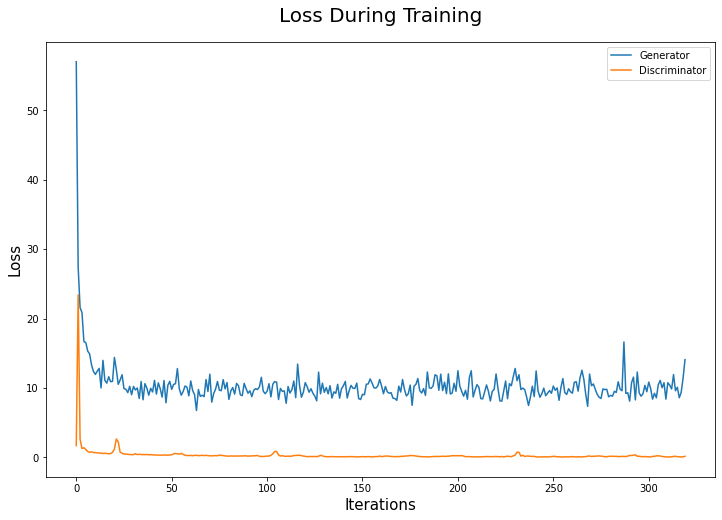

In [14]:
model = train_model(10, verbose=True)

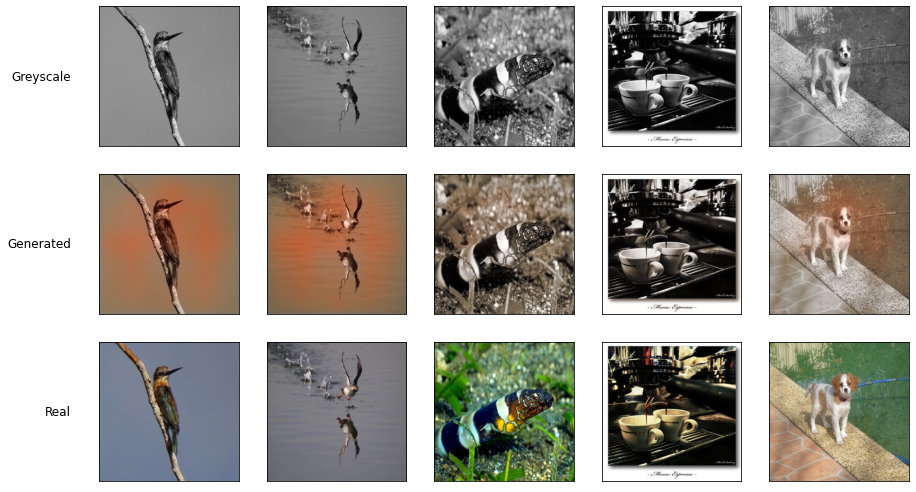

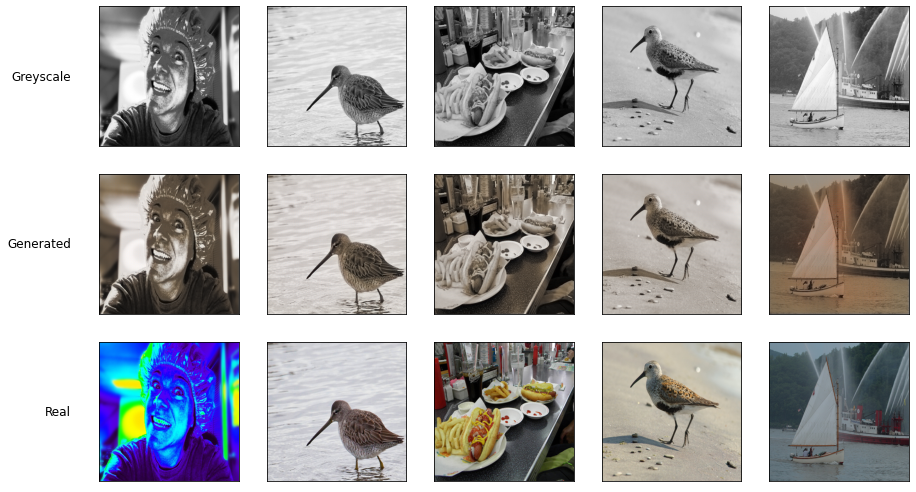

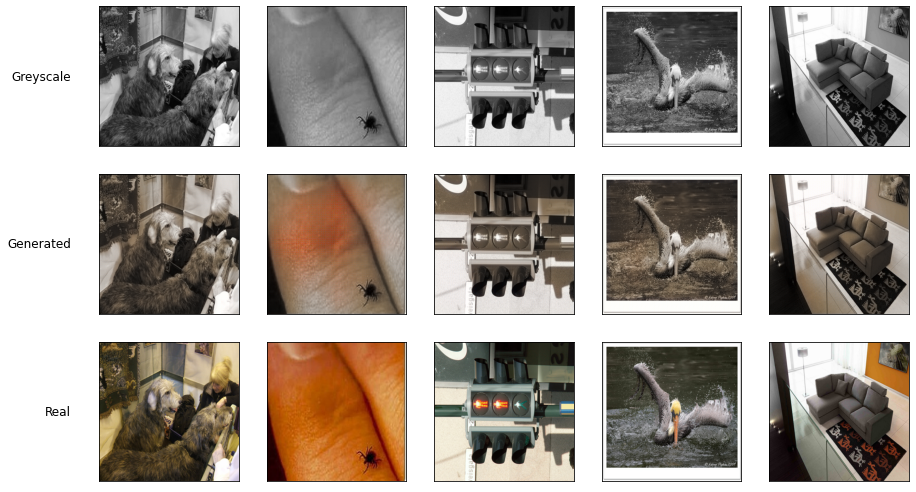

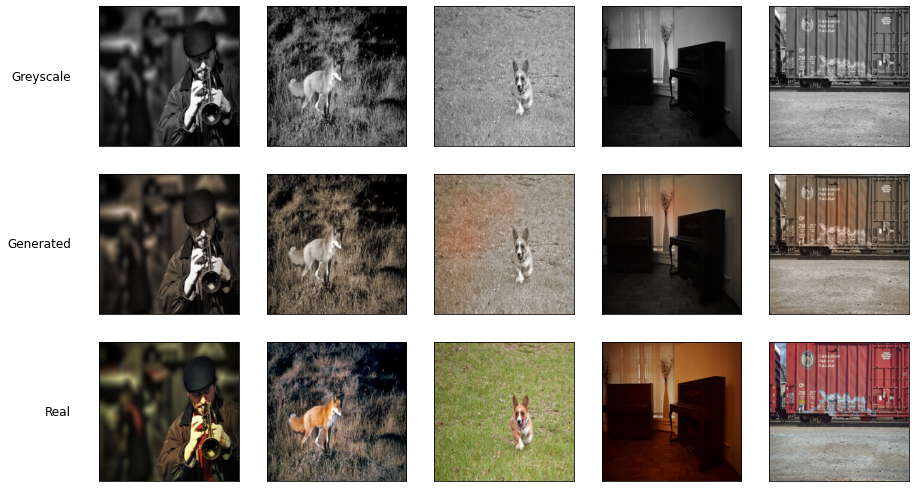

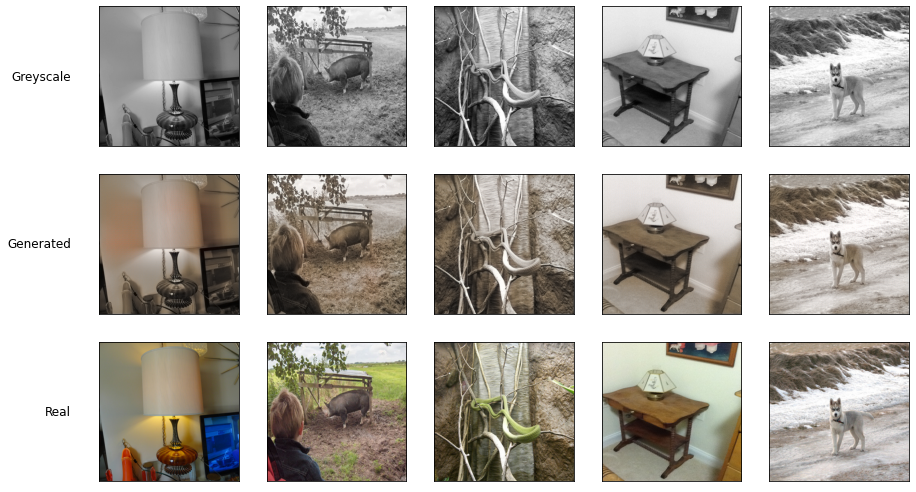

In [15]:
for i in range(5):
    
    print()
    visualize(model, next(iter(test_dl)))

## References

https://github.com/moein-shariatnia/Deep-Learning/tree/main/Image%20Colorization%20Tutorial